In [183]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



## Challenge 1
Load the data into a pandas dataframe. Replace 'y's with 1s, 'n's with 0s.

Now, almost every representative has a ?. This represents the absence of a vote (they were absent or some other similar reason). If we dropped all the rows that had a ?, we would throw out most of our data. Instead, we will replace ? with the best guess in the Bayesian sense: in the absence of any other information, we will say that the probability of the representative saying YES is the ratio of others that said YES over the whole votes.

So, convert each ? to this probability (when yes=1 and no=0, this is the mean of the column)

In [52]:
def read_data(filename):
    with open(filename) as f:
        data = pd.read_csv(f)
        
    return data

In [76]:
congressional_data = read_data('house-votes-84.csv')

In [62]:
vote_cols = [str(i) for i in range(1,17)]

In [63]:
#vote_cols

In [80]:
congressional_data[congressional_data == 'y'] = 1
congressional_data[congressional_data == 'n'] = 0
for i in vote_cols:
    congressional_data[i][congressional_data[i] == '?'] = congressional_data[i].value_counts()[1]/\
                                                (congressional_data[i].value_counts()[1]+\
                                                 congressional_data[i].value_counts()[0])

In [188]:
#congressional_data

## Challenge 2

Split the data into a test and training set. Use this function:

    from sklearn.cross_validation import train_test_split

In [84]:
train, test = train_test_split(congressional_data, test_size=0.30, random_state=4444)

## Challenge 3

Using scikit.learn's KNN algorithm, train a model that predicts the party (republican/democrat):

    from sklearn.neighbors import KNeighborsClassifier

Try it with a lot of different k values (number of neighbors), from 1 to 20, and on the test set calculate the accuracy (number of correct predictions / number of all predictions) for each k

You can use this to calculate accuracy:

    from sklearn.metrics import accuracy_score

Which k value gives the highest accuracy?

In [164]:
def findMaxKNN(train, test):
    accuracy_scores = []
    k_values = range(1,21)
    
    for k in k_values:
        party_model = KNeighborsClassifier(n_neighbors=k)
        party_model.fit(train[vote_cols], train.Party)
        test_prediction = party_model.predict(test[vote_cols])
        acc_score = accuracy_score(test.Party, test_prediction)
        accuracy_scores.append(acc_score)
        
    max_k = np.argmax(accuracy_scores) + 1
        
    return (max_k, accuracy_scores[max_k])
    
    

In [165]:
findMaxKNN(train,test)

(6, 0.91603053435114501)

## Challenge 4

Make a similar model but with LogisticRegression instead, calculate test accuracy.

In [135]:
def logRegAcc(train,test): 
    logreg_model = LogisticRegression()
    logreg_model.fit(train[vote_cols], train.Party)
    test_prediction = logreg_model.predict(test[vote_cols])
    
    return accuracy_score(test.Party, test_prediction)

In [168]:
logreg_acc = logRegAcc(train,test)

<class 'numpy.ndarray'>


## Challenge 5

Make a bar graph of democrats and republicans. How many of each are there?

Make a very simple predictor that predicts 'democrat' for every incoming example.

Just make a function that takes in an X --an array or matrix with input examples--, and returns an array of the same length as X, where each value is 'democrat'. For example, if X is three rows, your function should return ['democrat','democrat','democrat']. Make a y_predicted vector using this and measure its accuracy.

Do the same with predicting 'republican' all the time and measure its accuracy.

[<matplotlib.text.Text at 0x10ba93b70>, <matplotlib.text.Text at 0x10bc3f1d0>]

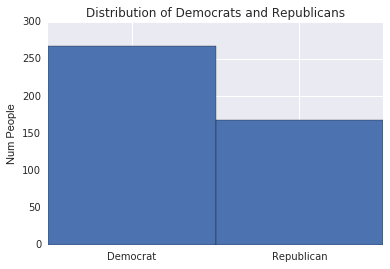

In [122]:
ind = np.array([1,2])
offset = .5

fig, ax = plt.subplots()
pols = ax.bar(ind, congressional_data.Party.value_counts(), width=1)

ax.set_ylabel('Num People')
ax.set_title('Distribution of Democrats and Republicans')
ax.set_xticks(ind+offset)
ax.set_xticklabels(('Democrat', 'Republican'))

In [119]:
congressional_data.Party.value_counts()

democrat      267
republican    168
Name: Party, dtype: int64

In [152]:
def getDemocratsOnly(df):
    length = len(df)
    return np.array(['democrat' for _ in range(length)])

In [153]:
#getDemocratsOnly(range(10))

In [154]:
def getRepublicansOnly(df):
    length = len(df)
    return np.array(['republican' for _ in range(length)])

In [159]:
def consPredAcc(test, cons='democrat'):
    if cons.lower() == 'democrat':
        test_prediction = getDemocratsOnly(test)
    elif cons.lower() == 'republican':
        test_prediction = getRepublicansOnly(test)
    else:
        return print('Bad cons value')
    
    return accuracy_score(test.Party, test_prediction)

In [162]:
dem_cons_acc = consPredAcc(test)
dem_cons_acc

0.58778625954198471

In [163]:
rep_cons_acc = consPredAcc(test, cons='republican')
rep_cons_acc

0.41221374045801529

## Challenge 6

Plot the accuracies as a function of k. Since k only matters for KNN, your logistic regression accuracy, 'democrat' predictor accuracy and 'republican' predictor accuracy will stay the same over all k, so each of these three will be a horizontal line. But the KNN accuracy will change with k.

In [166]:
def loopKNN(train, test):
    accuracy_scores = []
    k_values = range(1,21)
    
    for k in k_values:
        party_model = KNeighborsClassifier(n_neighbors=k)
        party_model.fit(train[vote_cols], train.Party)
        test_prediction = party_model.predict(test[vote_cols])
        acc_score = accuracy_score(test.Party, test_prediction)
        accuracy_scores.append(acc_score)
        
    max_k = np.argmax(accuracy_scores) + 1
        
    return k_values, accuracy_scores

In [169]:
k_values, y_knn = loopKNN(train,test)
y_logreg = [logreg_acc for _ in k_values]
y_consdem = [dem_cons_acc for _ in k_values]
y_consrep = [rep_cons_acc for _ in k_values]

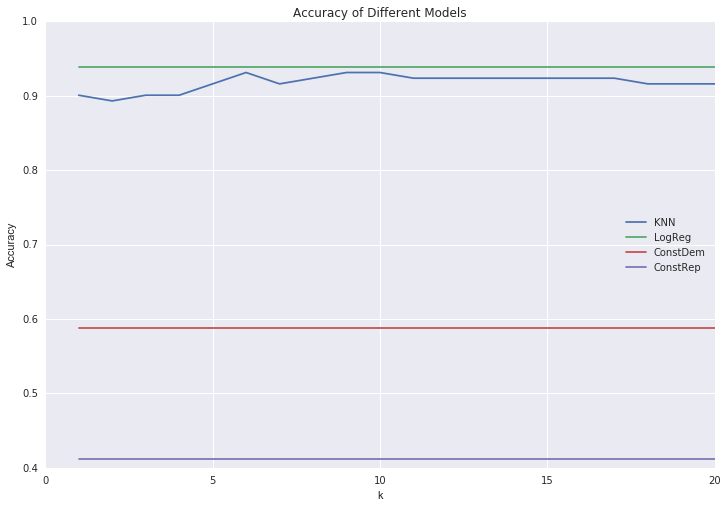

In [182]:
fig,ax = plt.subplots()

ax.plot(k_values, y_knn, label='KNN')
ax.plot(k_values, y_logreg, label='LogReg')
ax.plot(k_values, y_consdem, label='ConstDem')
ax.plot(k_values, y_consrep, label='ConstRep')

fig.set_size_inches(12, 8, forward=True)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.legend(loc='best')

## Challenge 7

Plot a learning curve for the logistic regression model. But instead of going through the painstaking steps of doing it yourself, use this function:

    from sklearn.learning_curve import learning_curve

This will give you the m, training errors and testing errors. All you need to do is plot them. You don't even need to give it separate training/test sets. It will do crossvalidation all by itself. Easy, isn't it? : ) Remember, since it does cross-validation, it doesn't have a single training error or test error per m value. Instead, it has one for each fold (separate partition) of the cross validation. A good idea is to take the mean of these errors from different folds. This gives you a meaningful single number per m. What I mean is that doing something like:

    train_cv_err = np.mean(train_err, axis=1)
    test_cv_err = np.mean(ts_err, axis=1)

Before plotting m vs train_cv_err and m vs test_cv_err, where train_err and test_err are the vectors returned by the learning curve function. The np.mean(...., axis=1) means take the mean along axis 1 (axis 1 is the columns axis-- for each row, you have a bunch of columns, each corresponding to a cross validation fold, you are averaging these columns for each row).

Draw the learning curve for KNN with the best k value as well.

In [199]:
train_sizes = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1]

In [200]:
train_sizes_abs, train_err, test_err = learning_curve(KNeighborsClassifier(n_neighbors=6), congressional_data[vote_cols], congressional_data.Party, train_sizes=train_sizes, cv=5)

In [201]:
train_cv_err = np.mean(train_err, axis=1)
test_cv_err = np.mean(test_err, axis=1)

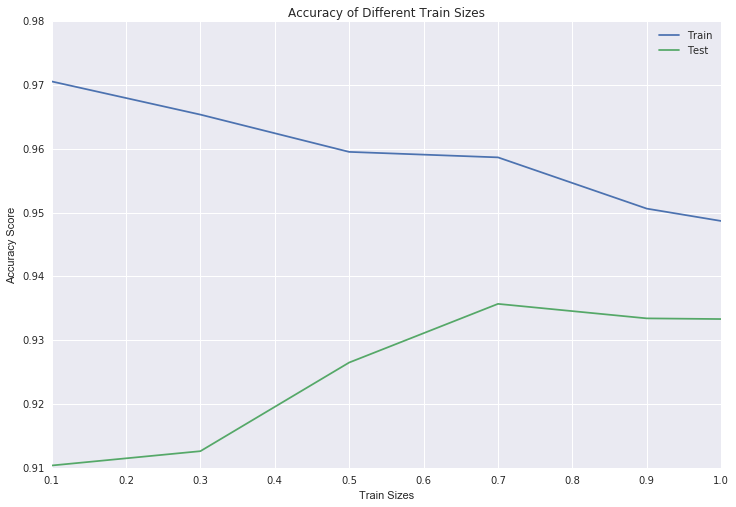

In [203]:
fig,ax = plt.subplots()

ax.plot(train_sizes, train_cv_err, label='Train')
ax.plot(train_sizes, test_cv_err, label='Test')

fig.set_size_inches(12, 8, forward=True)
plt.xlabel('Train Sizes')
plt.ylabel('Accuracy Score')
plt.title('Accuracy of Different Train Sizes')
plt.legend(loc='best')

## Challenge 8

This is a preview of many other classification algorithms that we will go over. Scikit.learn has the same interface for all of these, so you can use them exactly the same way as you did LogisticRegression and KNeighborsClassifier. Use each of these to classify your data and print the test accuracy of each:

Gaussian Naive Bayes

    from sklearn.naive_bayes import GaussianNB
    
SVM (Support Vector Machine) Classifier

    from sklearn.svm import SVC

Decision Tree

    from sklearn.tree import DecisionTreeClassifier

Random Forest

    from sklearn.ensemble import RandomForestClassifier